In [1]:
import time
import bs4 as bs
import numpy as np
import pandas as pd
import random
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from random import sample
import telebot

In [2]:
token = '############'
bot = telebot.TeleBot(token)

In [3]:
def atualiza_tickers():
    
    company_name = []
    company_ticker = []
    number = 10

    url = 'https://www.investopedia.com/terms/d/djia.asp'
    html = requests.get(url)
    soup = bs.BeautifulSoup(html.text)

    table =  soup.find('table', {'class':'mntl-sc-block-table__table'})
    odd_rows = table.findAll('tr')[2:]

    for i in odd_rows:
        name = i.findAll('td')[0].text
        ticker = i.findAll('td')[1].text
        company_name.append(name)        
        company_ticker.append(ticker)

    generator = pd.DataFrame({'Name': company_name, 'Ticker': company_ticker})
    generator.to_csv('indices.csv')

In [4]:
def atualiza_dados():

    generator = pd.read_csv('indices.csv', index_col=0)
    
    labels = generator['Name']
    assets = generator['Ticker']

    start0 = '01/01/2019'

    prices_df = pd.DataFrame()

    for a,b in zip(labels, assets):
        prices_df[a] = wb.DataReader(b, data_source = 'yahoo', start = start0)['Adj Close']
        
    prices_df.to_csv('prices_df.csv')

In [5]:
def gerador_portfolio():
    
    numero_carteiras = 20000    
    number = 10
    stocks = 5
    
    generator = pd.read_csv('indices.csv', index_col=0)
    
    raffle = sample(range(30), number)
    raffle.sort()
    generator = generator.loc[raffle]
    
    prices_df = pd.read_csv('prices_df.csv', index_col=0)
    prices_df = prices_df.iloc[:, raffle]
    
    returns = (prices_df/prices_df.shift(1)) - 1
    ret_anual = returns.mean()*250
    cov_anual = returns.cov()*250
    
    retorno_carteira, peso_acoes, volatilidade_carteira, sharpe_ratio = [],[],[],[]
    acoes = prices_df.columns
    numero_acoes = prices_df.shape[1]
    np.random.seed(42)

    for cada_carteira in range (numero_carteiras):
        peso = np.random.random(numero_acoes)
        peso /= np.sum(peso)
        retorno = np.dot(peso, ret_anual)
        volatilidade = np.sqrt(np.dot(peso.T, np.dot(cov_anual, peso)))
        sharpe = retorno/volatilidade
        sharpe_ratio.append(sharpe)
        retorno_carteira.append(retorno)
        volatilidade_carteira.append(volatilidade)
        peso_acoes.append(peso)
    
    carteira = {'Retorno': retorno_carteira, 'Volatilidade': volatilidade_carteira, 'Sharpe Ratio': sharpe_ratio}
    for contar, acao in enumerate(acoes):
        carteira[acao] = [Peso[contar] for Peso in peso_acoes]
    carteira = pd.DataFrame(carteira)
    colunas = ['Retorno', 'Volatilidade', 'Sharpe Ratio'] + [acao for acao in acoes]
    carteira = carteira[colunas]

    carteira_sharpe = carteira.loc[carteira['Sharpe Ratio'] == carteira['Sharpe Ratio'].max()]
    carteira_min_variancia = carteira.loc[carteira['Volatilidade'] == carteira['Volatilidade'].min()]

    x2 = float(carteira_sharpe['Volatilidade'])
    x1 = float(carteira_min_variancia['Volatilidade'])
    y2 = float(carteira_sharpe['Retorno'])
    y1 = float(carteira_min_variancia['Retorno'])

    x = np.linspace(x1, x2, 50)
    y = np.linspace(y1, y2, 50)

    ret = np.array(carteira['Retorno'])
    vol = np.array(carteira['Volatilidade'])
    idx = carteira.index
    a = np.array([x1, y1])
    b = np.array([x2, y2])
    aux, tmp = 0, 0
    for i in range(0, len(ret), 1):
        p = np.array([vol[i], ret[i]])
        if np.cross(p-a, b-a) < 0:
            if abs(np.cross(p-a, b-a)) > aux:
                aux = abs(np.cross(p-a, b-a))
                tmp = idx[i]
    carteira_tang = carteira.loc[carteira.index == tmp]

    def best_weights(carteira, k):
        aux = carteira.iloc[: , 3:].T.sort_values(by=[float(carteira.index[0])], ascending=False)
        best_weights0 = aux[0:k]
        best_weights0 = best_weights0/float(aux[0:k].sum())
        best_weights0 = best_weights0.T
        return best_weights0

    best_weights_sharpe = best_weights(carteira_sharpe, stocks)
    
    labels = best_weights_sharpe.columns
    labels = labels.tolist()
    weights = best_weights_sharpe.values
    weights = weights[0]
    
    cores_grafico = ['#2d2e3f', '#ce3450', '#e2d6ca', '#99b8c1', '#e6ba3d']
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="auto"))
    ax.pie(weights, autopct='%.1f%%', pctdistance=1.13, colors=cores_grafico, normalize=False)
    ax.legend(labels, title="Carteira", loc="center left",bbox_to_anchor=(1.03, 0, 1, 1))
    ax.set_title("Portfolio")
    plt.savefig("Portfolio.jpg")

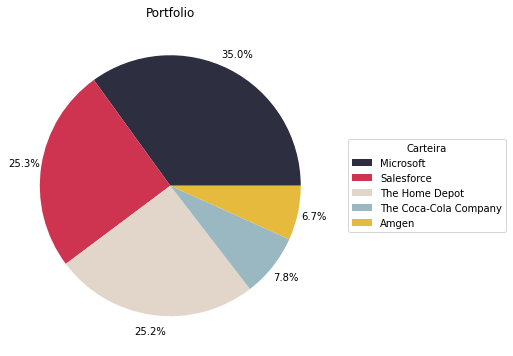

In [6]:
def atualiza_cotacoes(mensagem):
    hora_atual = time.ctime()
    hora_atual = hora_atual.split()
    
    if (hora_atual[3] == '20:00'):
        atualiza_tickers()
        atualiza_dados()
        msg = f'Dados atualizados: {hora_atual[3]}h'        
        bot.send_message('1234567890', msg)

def envia_portfolio(mensagem):
    gerador_portfolio()
    bot.send_photo(str(mensagem.from_user.id), photo=open('Portfolio.jpg', 'rb'))
    
@bot.message_handler(commands=["generator"])
def generator(mensagem):
    msg = 'Carregando...'
    bot.send_message(str(mensagem.from_user.id), msg)
    envia_portfolio(mensagem)
    msg = 'Para sua segurança os mantenha por pelo menos um ano!'
    bot.send_message(str(mensagem.from_user.id), msg)

def verificar(mensagem):
    return True

@bot.message_handler(func=verificar)
def responder(mensagem):
    texto = """
    Seja bem vindo ao gerador de portfolio!
    
    Clique no item para continuar:
     /generator Gerar portfolio
     
    Responder qualquer outra coisa não vai funcionar"""
    bot.send_message(str(mensagem.from_user.id), texto)
    
bot.polling()